In [1]:
import numpy as np
import control as ct
from planar_quad import PlanarQuad
import matplotlib.pyplot as plt

In [2]:
mass = 0.6
length = 0.2
inertia = 0.15
gravity = 9.81
dt = 0.01
quad = PlanarQuad(dt, mass, length, inertia, gravity)
A, B = quad.linear_dyn(np.zeros((6, )), np.array([quad.m * quad.g / 2, quad.m * quad.g / 2]))
C = np.array([[1, 0, 0, 0, 0, 0],[0, 0, 1, 0, 0, 0]])
# Start with a diagonal weighting
Q_ctrl = np.array([[1e0, 0., 0., 0., 0., 0.],
                           [0., 1e0, 0., 0., 0., 0.],
                           [0., 0., 1e0, 0., 0., 0.],
                           [0., 0., 0., 1e0, 0., 0.],
                           [0., 0., 0., 0., 1e0, 0.],
                           [0., 0., 0., 0., 0., 1e0]])

R_ctrl = np.array([[1e2, 0.],
                           [0., 1e2]])

K, _, _ = ct.dlqr(A, B, Q_ctrl, R_ctrl)  

Q_est = 1*np.eye(6)
R_est = 1*np.eye(2)

L, _, _ = ct.dlqe(A, np.eye(6), C, Q_est, R_est)  

A_delta = np.block([[A-B@K, B@K, np.zeros((6,6))], 
                   [np.zeros((6,6)), A-L@C@A, np.zeros((6,6))],
                   [np.zeros((6,6)), np.zeros((6,6)), (np.eye(6) - L@C)@A - B@K]])

B_delta = np.block([[np.zeros((6,2))],
                    [-L@np.eye(2)],
                    [L@np.eye(2)]
                    ])
W_delta = np.block([[np.eye(6), np.zeros((6,2))],
                    [(np.eye(6) - L@C), -L],
                    [np.zeros((6,6)),np.zeros((6,2))]])

C_tilde = np.array([[1, 0, 0, 0, 0, 0],[0, 0, 1, 0, 0, 0]])
C_delta = np.block([[C_tilde,np.zeros((2,6)),np.zeros((2,6))],
                    [np.zeros((2,6)),np.zeros((2,6)),C_tilde]])
M = np.block([np.zeros((2,6)),np.zeros((2,6)),-C])

In [3]:
import cvxpy as cp
from scipy.linalg import sqrtm

def solve_lmi(A, B, eta, r_max=1, n_states=6, verbose=False):
    ## M Kothare LMI Implementation for constant reference tracking
    n = n_states*3 # Augmented state dim
    m = B.shape[1] # Attack vector dim
    Q = cp.Variable((n,n), PSD=True)
    G = cp.Variable((n,n))
    Y = cp.Variable((m,n))

    gamma = cp.Variable()
    
    T_1 = np.zeros((6,6))
    T_1[0,0] = 1
    T_1[2,2] = 1
    T_1[4,4] = 1
    T = np.block([T_1, np.zeros((6,6)),np.zeros((6,6))])

    
    Q_curly = 1*(T.T@np.eye(n_states)@T)

    block_eq1 = cp.bmat([
        [G + G.T - Q, G.T@A.T+Y.T@B.T, G.T@sqrtm(Q_curly)],
        [A@G+B@Y,  Q,  np.zeros((n,n))],
        [sqrtm(Q_curly)@G,np.zeros((n,n)), gamma*np.eye(n)]])
    
    block_eq2 = cp.bmat([
        [np.eye(1), eta.T],
        [eta,Q]])
    
    # #Component wise output constraints
    # M_3 = np.zeros((1,6))
    # M_3[0,0] = 1
    # M = np.block([np.zeros((1,6)), np.zeros((1,6)), M_3])

    # block_eq3 = cp.bmat([
    #     [G + G.T - Q, (A@G+B@Y).T@M.T],
    #     [M@(A@G+B@Y), r_max**2*np.eye(1)]])
    
    # M_3 = np.zeros((1,6))
    # M_3[0,2] = 1
    # M = np.block([np.zeros((1,6)), np.zeros((1,6)), M_3])
    # block_eq4 = cp.bmat([
    #     [G + G.T - Q, (A@G+B@Y).T@M.T],
    #     [M@(A@G+B@Y), r_max**2*np.eye(1)]])
    

    block_eq5 = cp.bmat([
        [1*np.eye(2), Y],
        [Y.T,Q]])
    const = [block_eq1 >> 0, block_eq2>>0, block_eq5>>0]#, block_eq4>>0, block_eq5>>0]
    prob = cp.Problem(cp.Minimize(gamma), constraints = const)
    try:
        prob.solve(solver = cp.MOSEK, verbose=verbose)
        cost = gamma.value
        return {
            'cost': cost,
            'F': np.round(np.array(Y.value @ np.linalg.inv(G.value)), 3),
            'Q': np.round(np.array(Q.value), 3),
            'gamma': gamma.value
        }

    except Exception as e:
        print(e)
        cost = -1    
        return {
            'cost': cost,
        }   
   
res = solve_lmi(A_delta, B_delta, np.zeros((18,1)),  n_states=6)

In [4]:
mass = 0.6
length = 0.2
inertia = 0.15
gravity = 9.81
dt = 0.01
quad = PlanarQuad(dt, mass, length, inertia, gravity)
A, B = quad.linear_dyn(np.zeros((6, )), np.array([quad.m * quad.g / 2, quad.m * quad.g / 2]))
C = np.array([[1, 0, 0, 0, 0, 0],[0, 0, 1, 0, 0, 0]])

import numpy as np

def gen_uniq_floats(lo, hi, n):
    out = np.empty(n)
    needed = n
    while needed != 0:
        arr = np.random.uniform(lo, hi, needed)
        uniqs = np.setdiff1d(np.unique(arr), out[:n-needed])
        out[n-needed: n-needed+uniqs.size] = uniqs
        needed -= uniqs.size
    np.random.shuffle(out)
    return out.tolist()



indices = [1]
indices+=gen_uniq_floats(0.9, 1.1, 50)

print(indices)

state_arr = []
state_est_arr = []
test_stat_arr = []

for idx in indices:

    # Start with a diagonal weighting
    Q_ctrl = idx*np.array([[1e0, 0., 0., 0., 0., 0.],
                            [0., 1e0, 0., 0., 0., 0.],
                            [0., 0., 1e0, 0., 0., 0.],
                            [0., 0., 0., 1e0, 0., 0.],
                            [0., 0., 0., 0., 1e0, 0.],
                            [0., 0., 0., 0., 0., 1e0]])

    R_ctrl = idx*np.array([[1e2, 0.],
                            [0., 1e2]])

    K, _, _ = ct.dlqr(A, B, Q_ctrl, R_ctrl)  

    Q_est = 1*np.eye(6)
    R_est = 1*np.eye(2)

    L, _, _ = ct.dlqe(A, np.eye(6), C, Q_est, R_est)  

    A_delta = np.block([[A-B@K, B@K, np.zeros((6,6))], 
                    [np.zeros((6,6)), A-L@C@A, np.zeros((6,6))],
                    [np.zeros((6,6)), np.zeros((6,6)), (np.eye(6) - L@C)@A - B@K]])

    B_delta = np.block([[np.zeros((6,2))],
                        [-L@np.eye(2)],
                        [L@np.eye(2)]
                        ])
    W_delta = np.block([[np.eye(6), np.zeros((6,2))],
                        [(np.eye(6) - L@C), -L],
                        [np.zeros((6,6)),np.zeros((6,2))]])

    C_tilde = np.array([[1, 0, 0, 0, 0, 0],[0, 0, 1, 0, 0, 0]])
    C_delta = np.block([[C_tilde,np.zeros((2,6)),np.zeros((2,6))],
                        [np.zeros((2,6)),np.zeros((2,6)),C_tilde]])
    M = np.block([np.zeros((2,6)),np.zeros((2,6)),-C])



    N = 700
    t = np.zeros([N+1,])
    x0 = np.array([0.0, 0., 0., 0., 0, 0.])

    eta = np.empty([18, N+1])
    eta_est = np.empty([18, N+1])
    a = np.empty([2, N+1])


    eta[:,0] = np.block([x0, np.zeros(6), np.zeros(6)])
    eta_est[:,0] = np.block([x0, np.zeros(6), np.zeros(6)])

    delta = np.empty([6, N+1])
    delta[:,0] = np.zeros(6)



    gamma = np.zeros([N,])
    det_stat = np.zeros(N)
    det_stat_attack = np.zeros(N)

    a[:,0] =  np.array([0.0,0])
    a_star = np.array([0.0,0])
    r_max = 5

    t = np.zeros([N+1,])
    x = np.empty([6, N+1])
    x_est = np.empty([6, N+1])
    x_est_0 = np.empty([6, N+1])

    x[:,0] = x0
    x_est[:,0] = x0
    x_est_0[:,0] = x0


    A, B = quad.linear_dyn(np.zeros((6, )), np.array([quad.m * quad.g / 2, quad.m * quad.g / 2]))
    Q_delta_est = np.eye(18)
    R_delta_est = np.eye(4)
    Lo, _, _ = ct.dlqe(A_delta, np.eye(18), C_delta, Q_delta_est, R_delta_est) 

    print(idx)
    for i in range(N): 
        eta_star = np.zeros((18,))
        eta_star[0] = a_star[0]
        eta_star[2] = a_star[1]
        eta_star[6] = a_star[0]
        eta_star[8] = a_star[1]
        eta_star[12] = -a_star[0]
        eta_star[14] = -a_star[1]

        w = 0.001*np.random.randn(6)
        v = 0.1*np.random.randn(2)
        w_tilde = np.block([w,v])
        
        if (i>200):
            a_star = np.array([min(0.01 + i*0.002, 1.5), 0.0])
            err = eta_est[:,i] - eta_star
            res = solve_lmi(A_delta, B_delta, np.reshape(err,(18,1)), r_max, n_states=6, verbose = False)
            if res['cost']!=-1:
                F_obs = res['F']
                gamma[i] = res['gamma']
            #print(i, a[:,i], res['gamma'])

            a[:,i+1] = F_obs@(eta[:,i] - eta_star) 
        else:
            a[:,i+1] = a_star  
        eta[:,i+1] = A_delta@eta[:,i] + B_delta@((a[:,i])-a_star)+ W_delta@w_tilde
        
        v_eta = 0.00*np.random.randn(4)
        y_eta = C_delta@eta[:,i+1] + v_eta
        eta_est[:,i+1] = A_delta@eta_est[:,i] + B_delta@(a[:,i]-a_star)  + Lo@(y_eta - C_delta@A_delta@eta_est[:,i])


        x[:,i+1] = A@x[:,i] - B@K@x_est[:,i] + w 
        y = a[:,i] + v + C@(x[:,i+1]) - a_star
        y_0 = C@x[:,i+1] + v

        x_est[:,i+1] = (A - B@K)@x_est[:,i] + L@(y - C@((A - B@K)@x_est[:,i]))
        x_est_0[:,i+1] = A@x_est_0[:,i] - B@K@(x_est[:,i]) + L@(y_0 - C@(A@x_est_0[:,i] - B@K@(x_est[:,i])))
        delta[:,i+1] = ((np.eye(6) - L@C)@A - B@K)@delta[:,i] + L@(a[:,i] - a_star) 
        det_stat_attack[i] = np.linalg.norm(y - C@((A - B@K)@x_est[:,i]))**2
        det_stat[i] = np.linalg.norm(y_0 - C@(A@x_est_0[:,i] - B@K@(x_est[:,i])))**2

        t[i+1] = t[i] + 0.01


    state_arr.append(x)
    state_est_arr.append(x_est)
    test_stat_arr.append(det_stat_attack)

[1, 1.0573794329220039, 1.0298040984553671, 0.9114481422774589, 1.0928993532553317, 0.9045156523752605, 0.9719256761836603, 0.9856665781869361, 1.0259962240225429, 0.9545598713098038, 0.990296064415521, 0.9133956948659941, 1.032378563766821, 1.0471749933899304, 0.9938064293905817, 1.0712660045758249, 0.9184915563993733, 1.027665525087292, 1.042597536403811, 0.9408196901906876, 1.0528592128659215, 0.9816558087588839, 1.0370437801763068, 0.9669174638883233, 0.9521860168117561, 1.0644710180796348, 1.0896173576900765, 0.9530691355892703, 1.0930558077246673, 1.0539265521643755, 1.0224154917996093, 1.0684322595902755, 0.9627153483399697, 1.0528277257036482, 1.0120044924199825, 1.0292810698855308, 0.9069610309740261, 1.0778041436823373, 1.0601353448086235, 0.949790869381765, 1.0965456756324237, 0.9491242240499206, 0.9245430387697422, 1.0842952065772158, 0.9839048604560398, 1.0863200076094555, 1.0533913281391452, 0.9759320499977225, 0.9578688509402615, 0.9812050116361718, 0.9391172309180489]
1

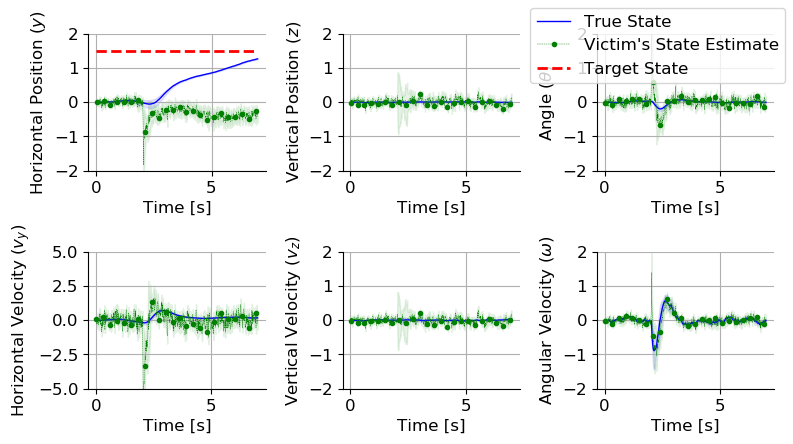

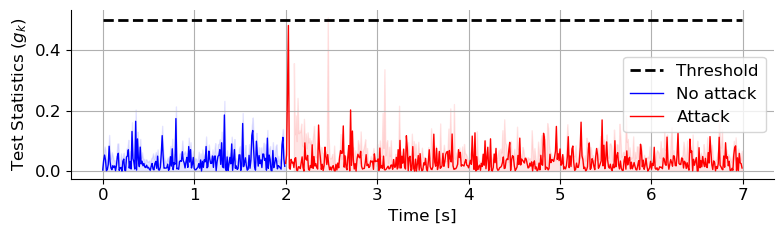

In [29]:
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = True
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['font.size'] = 12
fig = plt.figure(figsize=[8,4.5])

state = np.array(state_arr[18:38])
state_est = np.array(state_est_arr[18:38])
test_stat = np.array(test_stat_arr[18:38])


state_std = np.std(state, axis=0)
state_est_std = np.std(state_est, axis=0)
test_stat_std = np.std(test_stat, axis=0)

#plt.suptitle('Planner Quadrotor States (x,y,$\\theta$)')
plt.subplot(2,3,1)
plt.plot(t[1:], state[0, 0,1:], color = 'b')
plt.plot(t[1:], state_est[0, 0,1:], linestyle = '--', marker = '.', markevery=30, color = 'g', linewidth = 0.3)
plt.fill_between(t[1:], state[0, 0,1:] - state_std[0,1:],state[0, 0,1:] + state_std[0,1:], color='b', alpha=.1)
plt.fill_between(t[1:], state_est[0, 0,1:] - state_est_std[0,1:],state_est[0, 0,1:] + state_est_std[0,1:], color='g', alpha=.1)
# plt.plot(t[1:], state_est_0[1, 0,1:])
plt.plot(t[:-1], np.repeat((1.5), t.shape[0]-1),'--', color = 'r', linewidth = 2)

plt.ylim(-2,2)
plt.grid()
plt.ylabel('Horizontal Position ($y$)')
plt.xlabel('Time [s]')
#plt.legend(['x','$\hat{x}$','$\hat{x}^0$'])

plt.subplot(2,3,2)
plt.plot(t[1:], state[0, 2,1:], color = 'b')
plt.plot(t[1:], state_est[0, 2,1:], linestyle = '--', marker = '.', markevery=30, color = 'g', linewidth = 0.3)
plt.fill_between(t[1:], state[0, 2,1:] - state_std[2,1:],state[0, 2, 1:] + state_std[2,1:], color='b', alpha=.1)
plt.fill_between(t[1:], state_est[0, 2,1:] - state_est_std[2,1:],state_est[0, 2, 1:] + state_est_std[2,1:], color='g', alpha=.1)
#plt.plot(t, state_est_0[1, 2,:], alpha=0.7)
plt.ylim(-2,2)
plt.grid()
plt.ylabel('Vertical Position ($z$)')
plt.xlabel('Time [s]')
#plt.legend(['y', '$\hat{y}$', '$\hat{y}^0$'])

plt.subplot(2,3,3)
plt.plot(t[1:], state[0, 4,1:], color = 'b')
plt.plot(t[1:], state_est[0, 4,1:], linestyle = '--', marker = '.', markevery=30, color = 'g', linewidth = 0.3)
plt.fill_between(t[1:], state[0, 4,1:] - state_std[4,1:],state[0, 4, 1:] + state_std[4,1:], color='b', alpha=.1)
plt.fill_between(t[1:], state_est[0, 4,1:] - state_est_std[4,1:],state_est[0, 4, 1:] + state_est_std[4,1:], color='g', alpha=.1)
#plt.plot(t, state_est_0[1, 4,:], alpha=0.7)
plt.ylim(-2,2)
plt.grid()
plt.ylabel('Angle ($\\theta$)')
plt.xlabel('Time [s]')

#plt.legend(['$\\theta$','$\hat{\\theta}$', '$\hat{\\theta}^0$'])

plt.subplot(2,3,4)
plt.plot(t[1:], state[0, 1,1:], color = 'b')
plt.plot(t[1:], state_est[0, 1,1:], linestyle = '--', marker = '.', markevery=30, color = 'g', linewidth = 0.3)
plt.fill_between(t[1:], state[0, 1,1:] - state_std[1,1:],state[0, 1, 1:] + state_std[1,1:], color='b', alpha=.1)
plt.fill_between(t[1:], state_est[0, 1,1:] - state_est_std[1,1:],state_est[0, 1, 1:] + state_est_std[1,1:], color='g', alpha=.1)
#plt.plot(t, state_est_0[1, 1,:], alpha=0.7)
plt.ylim(-5,5)
plt.grid()
plt.ylabel('Horizontal Velocity ($v_y$)')
plt.xlabel('Time [s]')

#plt.legend(['$v_x$','$\hat{v}_x$', '$\hat{v}_x^0$'])
#plt.xlabel('Time [s]')

plt.subplot(2,3,5)
plt.plot(t[1:], state[0, 3,1:], color = 'b')
plt.plot(t[1:], state_est[0, 3,1:], linestyle = '--', marker = '.', markevery=30, color = 'g', linewidth = 0.3)
plt.fill_between(t[1:], state[0, 3,1:] - state_std[3,1:],state[0, 3, 1:] + state_std[3,1:], color='b', alpha=.1)
plt.fill_between(t[1:], state_est[0, 3,1:] - state_est_std[3,1:],state_est[0, 3, 1:] + state_est_std[3,1:], color='g', alpha=.1)
#plt.plot(t, state_est_0[1, 3,:], alpha=0.7)
plt.ylim(-2,2)
plt.grid()
plt.ylabel('Vertical Velocity ($v_z$)')
plt.xlabel('Time [s]')

#plt.legend(['$v_y$','$\hat{v}_y$', '$\hat{v}_y^0$'])
#plt.xlabel('Time [s]')

plt.subplot(2,3,6)
plt.plot(t[1:], state[0, 5,1:], color = 'b')
plt.plot(t[1:], state_est[0, 5,1:], linestyle = '--', marker = '.', markevery=30, color = 'g', linewidth = 0.3)
plt.fill_between(t[1:], state[0, 5,1:] - state_std[5,1:],state[0, 5, 1:] + state_std[5,1:], color='b', alpha=.1)
plt.fill_between(t[1:], state_est[0, 5,1:] - state_est_std[5,1:],state_est[0, 5, 1:] + state_est_std[5,1:], color='g', alpha=.1)
#plt.plot(t, state_est_0[1, 5,:], alpha=0.7)
plt.ylim(-2,2)
plt.grid()
plt.ylabel('Angular Velocity ($\omega$)')
plt.xlabel('Time [s]')
#plt.legend(['$\omega$','$\hat{\omega}$', '$\hat{\omega}^0$'])
#plt.xlabel('Time [s]')
labels = ['True State','Victim\'s State Estimate', 'Target State']#, 'Attacker\'s State Estimate']
fig.legend(labels, loc='upper right')
plt.tight_layout()
plt.savefig('attack.pdf')
# # we can also plot the control
# plt.figure()
# plt.title('Innovation Bias Due to Attack')
# plt.plot(t[:-1], np.linalg.norm(C@delta[:,:-1], axis=0))
# plt.plot(t[:-1], np.repeat((r_max), t.shape[0]-1))
# plt.grid()
# plt.legend(['$||{\epsilon}||$'])
# plt.xlabel('Time [s]')




# we can also plot the control
fig = plt.figure(figsize=[8,2.5])
# plt.plot(t[:-1], det_stat[0:])
plt.plot(t[:-1], np.repeat((0.5), t.shape[0]-1),'--', color = 'k', linewidth = 2)
plt.plot(t[:200], test_stat[0, 0:200], color = 'b')
plt.plot(t[200:-1], test_stat[11, 200:], color = 'r')
plt.fill_between(t[:200], 0, test_stat[0, 0:200] + test_stat_std[0:200], color='b', alpha=.1)
plt.fill_between(t[209:-1], 0, test_stat[0, 209:] + test_stat_std[209:], color='r', alpha=.1)

#plt.plot(t[:-1], det_stat_attack[0:]-det_stat[0:])
plt.grid()
plt.legend(['Threshold', 'No attack','Attack'])
plt.ylabel('Test Statistics ($g_k$)')
plt.xlabel('Time [s]')
plt.tight_layout()
plt.savefig('attack_residual.pdf')

u = -K@x_est
#quad.animate(state, u, goal=a_star)

In [99]:
state.shape

(5, 6, 701)